# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
train_transforms = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]
test_transforms = [
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose(train_transforms)
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose(test_transforms)
)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(classes)

Files already downloaded and verified
Files already downloaded and verified
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Train size: 50000
Test size: 10000
Train batch image tensor shape: torch.Size([128, 3, 32, 32])
Train batch label tensor shape: torch.Size([128])
cat


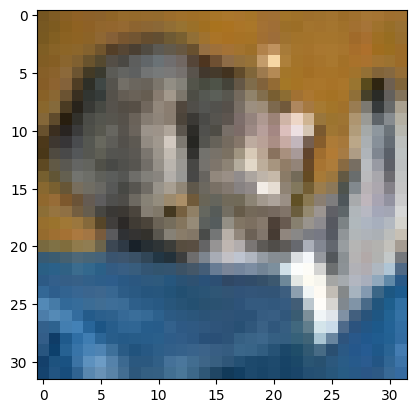

ship


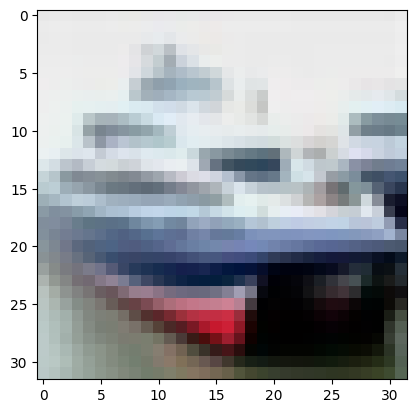

ship


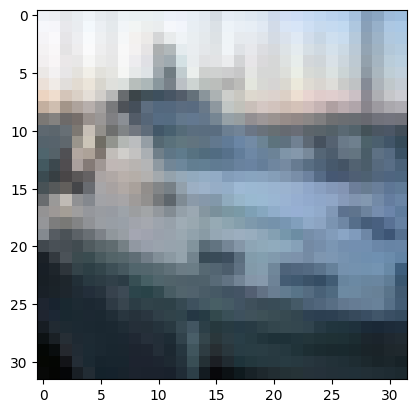

plane


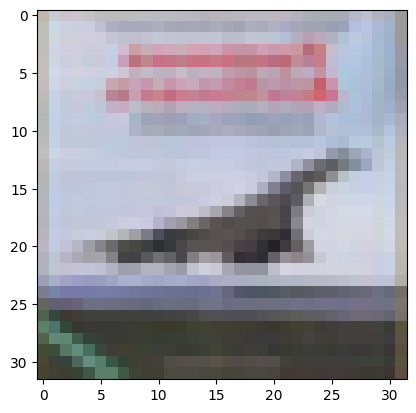

frog


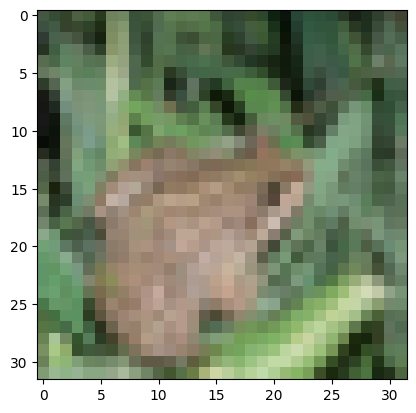

In [6]:
# Explore data
print("Train size:", len(trainset))
print("Test size:", len(testset))

images, labels = next(iter(trainloader))
print("Train batch image tensor shape:", images.shape)
print("Train batch label tensor shape:", labels.shape)

# view the test set without normalization
view_testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=False,
    transform=transforms.ToTensor()
)
view_testloader = torch.utils.data.DataLoader(view_testset, batch_size=8, shuffle=False, num_workers=2)

show5(view_testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [7]:
class SimpleCIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        logits = self.fc2(x)
        probs = F.softmax(logits, dim=1)
        return probs

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
# NLLLoss expects log probabilities, during training take log of model outputs.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCIFAR10CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
# Training 
epochs = 10
print_every = 250
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)                 
        log_outputs = torch.log(outputs + 1e-9) 
        loss = criterion(log_outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % print_every == 0:
            print(f"Epoch {epoch+1}/{epochs} - Batch {i+1} - Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    # test accuracy each epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)             
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    acc = 100.0 * correct / total
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}: avg_train_loss={avg_loss:.4f}, test_acc={acc:.2f}%")

Epoch 1/10 - Batch 250 - Loss: 1.5490
Epoch 1: avg_train_loss=1.6026, test_acc=54.78%
Epoch 2/10 - Batch 250 - Loss: 1.3615
Epoch 2: avg_train_loss=1.2348, test_acc=61.84%
Epoch 3/10 - Batch 250 - Loss: 1.1358
Epoch 3: avg_train_loss=1.0696, test_acc=67.54%
Epoch 4/10 - Batch 250 - Loss: 1.0900
Epoch 4: avg_train_loss=0.9571, test_acc=71.98%
Epoch 5/10 - Batch 250 - Loss: 0.7447
Epoch 5: avg_train_loss=0.8835, test_acc=73.42%
Epoch 6/10 - Batch 250 - Loss: 0.9136
Epoch 6: avg_train_loss=0.8289, test_acc=72.77%
Epoch 7/10 - Batch 250 - Loss: 0.8331
Epoch 7: avg_train_loss=0.7954, test_acc=75.23%
Epoch 8/10 - Batch 250 - Loss: 0.7702
Epoch 8: avg_train_loss=0.7572, test_acc=76.84%
Epoch 9/10 - Batch 250 - Loss: 0.5760
Epoch 9: avg_train_loss=0.7302, test_acc=76.28%
Epoch 10/10 - Batch 250 - Loss: 0.7167
Epoch 10: avg_train_loss=0.7046, test_acc=77.80%


Plot the training loss (and validation loss/accuracy, if recorded).

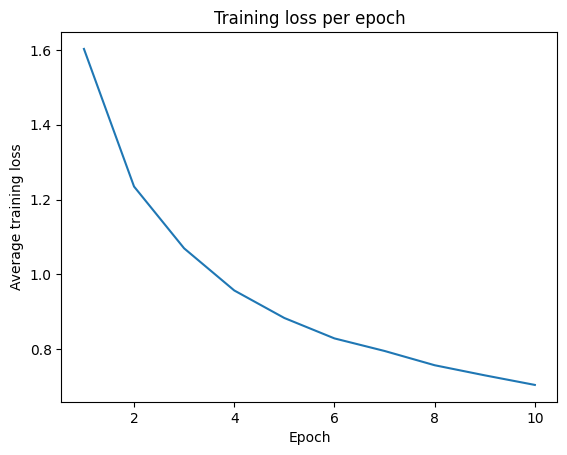

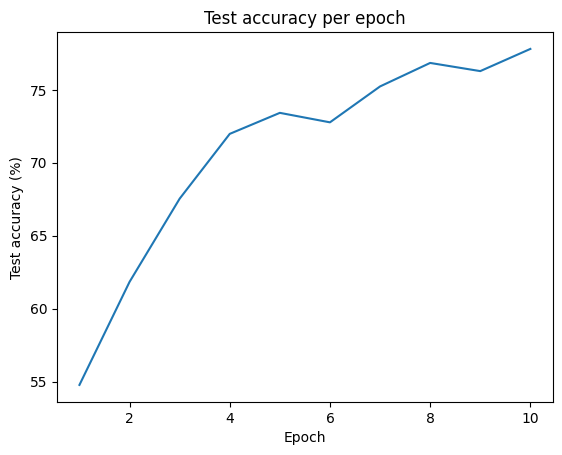

In [10]:
# Plot training loss and test accuracy
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Average training loss")
plt.title("Training loss per epoch")
plt.show()

plt.figure()
plt.plot(range(1, len(test_accuracies)+1), test_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Test accuracy (%)")
plt.title("Test accuracy per epoch")
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
# Test model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)  # probabilities
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
test_acc = 100.0 * correct / total
print(f"Test accuracy: {test_acc:.2f}% ({correct}/{total})")

Test accuracy: 77.80% (7780/10000)


## Saving your model
Using `torch.save`, save your model for future loading.

In [12]:
# Save model
torch.save(model.state_dict(), "cifar10_cnn.pth")
print("Saved weights to cifar10_cnn.pth")

Saved weights to cifar10_cnn.pth


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

Recommendation: Build in-house. The baseline CNN with basic augmentation achieved 77.8% test accuracy on CIFAR-10 in 10 epochs, exceeding Detectocorp’s 70% claim at low complexity and cost. State-of-the-art results above 96% rely on very large models and training budgets that are unnecessary for the present decision. We could have trained for more epochs (only 10!) and gotten better results, but at the cost of additional time and computation resources. 

The achieved accuracy came from standard normalization, random crop and horizontal flip, a 3-block CNN, Adam optimizer, and straightforward training on the provided loaders. This indicates that comparable or better accuracy can be obtained with modest engineering effort. Buying Detectocorp’s model offers limited benefit given current results.

If higher accuracy is required, incremental work should focus on swapping to a pretrained backbone (e.g., ResNet-18) with transfer learning, stronger augmentation and regularization, and simple schedulers; this typically yields 80–90% on CIFAR-10 with similar budgets. For the business use case, a detection model will be needed, so extend to pretrained detectors (e.g., Faster R-CNN or SSD) fine-tuned on in-domain roadside data. This path preserves control over latency, cost, and IP, and aligns with future domain adaptation needs. The project notebook is a bit dated, so methods have far advanced accuracy since the inception of this project. 

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).